In [105]:
# Importing the libraries
import pandas as pd
import geopandas as gpd
import h5py
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Efficient transit queries from r5py

#### Problem Statement:
The objective was to explore different strategies to create large random transit time queries from a r5py traveltime matrix.
This includes writing a large dataset to an HDF5 file efficiently, querying id's from points, finding a closest point and finally querying transit times form two random points.

## Experiment 1 - Storing travel time matrix
The dataset, initially stored in a CSV file, contained a significant number of rows, with key columns like `from_id`, `to_id`, and `travel_time`. The challenge was to optimize the HDF5 file creation process considering factors like processing time, file size, and compression ratio.

### Experimental Setup:
Three different approaches were tested:
1. **Direct Writing Through Pandas**: The first experiment involved writing the dataset directly to an HDF5 file using Pandas, without any preprocessing like NaN filtering or datatype conversion.
   
2. **Using Chunking and Compression**: The second experiment focused on preprocessing the data by filtering out NaN values, setting appropriate datatypes to save memory, and then writing the HDF5 file with both chunking and compression.

3. **Compression Without Chunking**: The final experiment also involved preprocessing the data (NaN filtering and datatype conversion) but used compression without chunking when writing the HDF5 file.

## Results:

Here's a markdown table summarizing the results of the three experiments:

| Strategy                                  | CSV File Size (bytes) | Total Rows Before Filtering | Total Rows After Filtering | Processing Time (seconds) | Writing Time (seconds) | HDF5 File Size (bytes) | Compression Ratio |
|-------------------------------------------|-----------------------|-----------------------------|----------------------------|--------------------------|-----------------------|------------------------|-------------------|
| Direct Writing Through Pandas             | 1,923,541,554         | 85,285,225                  | N/A                        | 33.42                    | 5.94                  | 43,748,297             | 43.97             |
| Using Chunking and Compression            | 1,923,541,554         | 85,285,225                  | 6,383,010                  | 35.23                    | 1.73                  | 16,350,848             | 117.64            |
| Compression Without Chunking              | 1,923,541,554         | 85,285,225                  | 6,383,010                  | 34.65                    | 0.67                  | 6,701,225              | 287.04            |

This table provides a clear comparison of the different strategies, highlighting the impact of preprocessing, chunking, and compression on the efficiency of writing large datasets to HDF5 files.

## Experiment 2 - Querying

Now we setup a simple object that turns this hdf5 into a dict for fast querying

Obviously the fastest load time comes from the hdf5 with the best compression

### Experiment Overview

In this experiment, we explored the efficiency of querying origin-destination (OD) pairs from a preprocessed OD matrix stored in an optimized data structure. The primary goal was to assess the performance scalability of the query process as the number of queried pairs increased. This is crucial for applications requiring rapid access to OD travel times, such as dynamic routing algorithms, traffic simulation models, and various geospatial analyses.

### Results

The results are summarized in the table below, showing both the total time taken to query a set number of OD pairs and the average time per individual query:

| Number of Queries | Total Query Time (seconds) | Average Time Per Call (seconds) |
|-------------------|----------------------------|---------------------------------|
| 1                 | 0.000005                   | 0.000005                        |
| 10                | 0.000023                   | 0.000002                        |
| 100               | 0.000197                   | 0.000002                        |
| 1,000             | 0.001486                   | 0.000001                        |
| 10,000            | 0.012771                   | 0.000001                        |

## Experiment 3: Querying Closest Points

In this experiment, we tested two methods for querying the closest points to a set of random coordinates using a dataset of origin points. The two methods compared are:

1. **get_closest_id function:** This method calculates the distance between each random coordinate and all origin points in the dataset and returns the ID of the closest origin point.

2. **get_closest_id_tree function:** This method uses a BallTree spatial indexing structure to efficiently find the closest origin point to each random coordinate and returns the ID of the closest origin point.

We measured the total time taken to query a varying number of random points and calculated the average time per query call for each method.

### Results

| Number of Random Points | get_closest_id (seconds) | get_closest_id_tree (seconds) |
|-------------------------|--------------------------|-------------------------------|
| 1                       | 0.015549                 | 0.000355                      |
| 10                      | 0.140009                 | 0.001297                      |
| 100                     | 1.309974                 | 0.013414                      |
| 1000                    | 12.895093                | 0.111098                      |
| 9000                    | 115.895936               | 1.005964                      |

## Experiment 4 -  Combining it all

Finally, what we really need is a way to get transit times between two random points.

| Query Count | Total Time (seconds) | Average Time per Call (seconds) |
|-------------|-----------------------|---------------------------------|
| 1           | 2.058234              | 2.058234                        |
| 10          | 2.055068              | 0.205507                        |
| 100         | 2.097684              | 0.020977                        |
| 1000        | 2.015695              | 0.002016                        |
| 9000        | 2.032059              | 0.000226                        |

This table summarizes the total time taken and the average time per call for querying different numbers of random OD pairs. While the total time remains the same, the average time per call is going down. This indicates that there is a 2 second overhead in the querying function.

But this can be avoided if you don't want the overhead of objectifying this process.

In [50]:
path_to_csv = "data/processed/transit_times_slow.csv"
path_to_hdf5 = "data/processed/od_matrix.h5"
path_to_origins = "data/processed/origins.csv"

In [25]:
print("Writing HDF5 directly through pandas")

# Start time for the entire process
start_time = time.time()

# Load the entire CSV into a DataFrame (ensure you have enough memory)
df = pd.read_csv(path_to_csv)

# Print size of csv file in bytes and total number of rows
print(f"Size of CSV file: {os.path.getsize(path_to_csv)} bytes")
print(f"Total number of rows: {len(df)}")

# Print the max of each column
print("Max of each column:")
print(df.max(axis=0))

# Record and print time for processing (loading CSV)
processing_time = time.time() - start_time
print(f"Time for processing: {processing_time:.2f} seconds")

# Write the DataFrame to an HDF5 file
with h5py.File(path_to_hdf5, 'w') as hdf5_file:
    # Create datasets for 'from_id', 'to_id', and 'travel_time'
    hdf5_file.create_dataset('from_id', data=df['from_id'].to_numpy(), dtype='i2', compression='gzip')
    hdf5_file.create_dataset('to_id', data=df['to_id'].to_numpy(), dtype='i2', compression='gzip')
    hdf5_file.create_dataset('travel_time', data=df['travel_time'].to_numpy(), dtype='i2', compression='gzip')

# Record and print time for writing HDF5
writing_time = time.time() - start_time - processing_time
print(f"Time for writing: {writing_time:.2f} seconds")

# Print size of HDF5 file in bytes and the compression ratio
hdf5_size = os.path.getsize(path_to_hdf5)
print(f"Size of HDF5 file: {hdf5_size} bytes")
print(f"Compression ratio: {os.path.getsize(path_to_csv) / hdf5_size:.2f}")

Writing HDF5 directly through pandas
Size of CSV file: 1923541554 bytes
Total number of rows: 85285225
Max of each column:
Unnamed: 0     85285224.0
from_id           16491.0
to_id             16491.0
travel_time         170.0
dtype: float64
Time for processing: 33.42 seconds
Time for writing: 5.94 seconds
Size of HDF5 file: 43748297 bytes
Compression ratio: 43.97


In [26]:
print( " Writing HDF5 using chunking and compression, dropping nans and appropriate datatypes")
# Start time for the entire process
start_time = time.time()

# Load the entire CSV into a DataFrame (ensure you have enough memory)
df = pd.read_csv(path_to_csv)

# Print size of csv file in bytes, total number of rows, and max of each column
print(f"Size of CSV file: {os.path.getsize(path_to_csv)} bytes")
print(f"Total number of rows before filtering: {len(df)}")

# Filter out rows with NaN values in the 'travel_time' column and drop the unnamed column
df = df.dropna(subset=['travel_time']).drop(columns=['Unnamed: 0'])

# Convert data types to save memory
df = df.astype({'from_id': 'int16', 'to_id': 'int16', 'travel_time': 'int16'})

# Print total number of rows after filtering and the max of each column
print(f"Total number of rows after filtering: {len(df)}")
print("Max of each column after processing:")
print(df.max(axis=0))

# Record and print time for processing (loading and cleaning CSV)
processing_time = time.time() - start_time
print(f"Time for processing: {processing_time:.2f} seconds")

# Write the DataFrame to an HDF5 file with chunking and compression
chunk_size = (1000,)  # Adjust based on your dataset and access patterns
with h5py.File(path_to_hdf5, 'w') as hdf5_file:
    # Create datasets for 'from_id', 'to_id', and 'travel_time' with chunking and compression
    hdf5_file.create_dataset('from_id', data=df['from_id'].to_numpy(), dtype='i2', compression='gzip', chunks=chunk_size)
    hdf5_file.create_dataset('to_id', data=df['to_id'].to_numpy(), dtype='i2', compression='gzip', chunks=chunk_size)
    hdf5_file.create_dataset('travel_time', data=df['travel_time'].to_numpy(), dtype='i2', compression='gzip', chunks=chunk_size)

# Record and print time for writing HDF5
writing_time = time.time() - start_time - processing_time
print(f"Time for writing: {writing_time:.2f} seconds")

# Print size of HDF5 file in bytes and the compression ratio
hdf5_size = os.path.getsize(path_to_hdf5)
print(f"Size of HDF5 file: {hdf5_size} bytes")
print(f"Compression ratio: {os.path.getsize(path_to_csv) / hdf5_size:.2f}")

 Writing HDF5 using chunking and compression, dropping nans and appropriate datatypes
Size of CSV file: 1923541554 bytes
Total number of rows before filtering: 85285225
Total number of rows after filtering: 6383010
Max of each column after processing:
from_id        16491
to_id          16491
travel_time      170
dtype: int16
Time for processing: 35.23 seconds
Time for writing: 1.73 seconds
Size of HDF5 file: 16350848 bytes
Compression ratio: 117.64


In [27]:
print( " Writing HDF5 without chunking, but with compression, dropping nans and appropriate datatypes")
# Start time for the entire process
start_time = time.time()

# Load the entire CSV into a DataFrame (ensure you have enough memory)
df = pd.read_csv(path_to_csv)

# Print size of csv file in bytes, total number of rows, and max of each column
print(f"Size of CSV file: {os.path.getsize(path_to_csv)} bytes")
print(f"Total number of rows before filtering: {len(df)}")

# Filter out rows with NaN values in the 'travel_time' column and drop the unnamed column
df = df.dropna(subset=['travel_time']).drop(columns=['Unnamed: 0'])

# Convert data types to save memory
df = df.astype({'from_id': 'int16', 'to_id': 'int16', 'travel_time': 'int16'})

# Print total number of rows after filtering and the max of each column
print(f"Total number of rows after filtering: {len(df)}")
print("Max of each column after processing:")
print(df.max(axis=0))

# Record and print time for processing (loading and cleaning CSV)
processing_time = time.time() - start_time
print(f"Time for processing: {processing_time:.2f} seconds")

# Write the DataFrame to an HDF5 file using only compression
with h5py.File(path_to_hdf5, 'w') as hdf5_file:
    # Create datasets for 'from_id', 'to_id', and 'travel_time' with compression
    hdf5_file.create_dataset('from_id', data=df['from_id'].to_numpy(), dtype='i2', compression='gzip')
    hdf5_file.create_dataset('to_id', data=df['to_id'].to_numpy(), dtype='i2', compression='gzip')
    hdf5_file.create_dataset('travel_time', data=df['travel_time'].to_numpy(), dtype='i2', compression='gzip')

# Record and print time for writing HDF5
writing_time = time.time() - start_time - processing_time
print(f"Time for writing: {writing_time:.2f} seconds")

# Print size of HDF5 file in bytes and the compression ratio
hdf5_size = os.path.getsize(path_to_hdf5)
print(f"Size of HDF5 file: {hdf5_size} bytes")
print(f"Compression ratio: {os.path.getsize(path_to_csv) / hdf5_size:.2f}")


 Writing HDF5 without chunking, but with compression, dropping nans and appropriate datatypes
Size of CSV file: 1923541554 bytes
Total number of rows before filtering: 85285225
Total number of rows after filtering: 6383010
Max of each column after processing:
from_id        16491
to_id          16491
travel_time      170
dtype: int16
Time for processing: 34.65 seconds
Time for writing: 0.67 seconds
Size of HDF5 file: 6701225 bytes
Compression ratio: 287.04


# Querying

Now we setup a simple object that turns this hdf5 into a dict for fast querying

Obviously the fastest load time comes from the hdf5 with the best compression

### Experiment Overview

In this experiment, we explored the efficiency of querying origin-destination (OD) pairs from a preprocessed OD matrix stored in an optimized data structure. The primary goal was to assess the performance scalability of the query process as the number of queried pairs increased. This is crucial for applications requiring rapid access to OD travel times, such as dynamic routing algorithms, traffic simulation models, and various geospatial analyses.

### Results

The results are summarized in the table below, showing both the total time taken to query a set number of OD pairs and the average time per individual query:

| Number of Queries | Total Query Time (seconds) | Average Time Per Call (seconds) |
|-------------------|----------------------------|---------------------------------|
| 1                 | 0.000005                   | 0.000005                        |
| 10                | 0.000023                   | 0.000002                        |
| 100               | 0.000197                   | 0.000002                        |
| 1,000             | 0.001486                   | 0.000001                        |
| 10,000            | 0.012771                   | 0.000001                        |


In [228]:
class ODMatrix:
    def __init__(self, hdf5_path):
        self.hdf5_path = hdf5_path
        self.travel_times_dict = {}
        self.preprocess_data()

    def preprocess_data(self):
        """Preprocess the data from the HDF5 file and store it in a dictionary for fast lookups."""
        with h5py.File(self.hdf5_path, 'r') as hdf5_file:


            # Proceed with the existing logic if datasets are present
            dataset_size = hdf5_file['from_id'].shape[0]
            batch_size = 10000  # Adjust based on your system's memory capacity

            for i in range(0, dataset_size, batch_size):
                from_ids = hdf5_file['from_id'][i:i+batch_size]
                to_ids = hdf5_file['to_id'][i:i+batch_size]
                travel_times = hdf5_file['travel_time'][i:i+batch_size]
                
                for from_id, to_id, travel_time in zip(from_ids, to_ids, travel_times):
                    self.travel_times_dict[(from_id, to_id)] = travel_time

    def query_travel_time(self, o_id, d_id):
        """Query the travel time for a given origin and destination ID pair."""
        return self.travel_times_dict.get((o_id, d_id), None)


In [229]:
# Create an instance of the ODMatrix class
od_matrix = ODMatrix(path_to_hdf5)

In [49]:

# List of the number of OD pairs to query in each experiment
num_pairs_list = [1, 10, 100, 1000, 10000]

# Convert the dictionary keys to a list once, outside the loop
od_pairs_list = list(od_matrix.travel_times_dict.keys())

# Pre-generate all random OD pairs and store them
random_od_pairs_dict = {}

for num_pairs in num_pairs_list:
    # Efficiently sample random OD pairs using random.sample()
    random_od_pairs = random.sample(od_pairs_list, num_pairs)

    # Store the random OD pairs
    random_od_pairs_dict[num_pairs] = random_od_pairs


In [231]:
o_id = 13614
d_id = 13511
travel_time = od_matrix.query_travel_time(o_id, d_id)
print(f"Travel time from {o_id} to {d_id}: {travel_time} minutes")

Travel time from 13614 to 13511: 54 minutes


In [48]:
# Iterate over the stored OD pairs and measure query times
for num_pairs, od_pairs in random_od_pairs_dict.items():
    # Query the travel time for each origin-destination pair and measure the total time taken
    start_time = time.perf_counter()
    for o_id, d_id in od_pairs:
        od_matrix.query_travel_time(o_id, d_id)
    total_query_time = time.perf_counter() - start_time

    # Calculate the average time per query call
    time_per_call = total_query_time / num_pairs

    # Print the total time and average time per call for querying the specified number of OD pairs
    print(f"Total time for querying {num_pairs} random OD pairs: {total_query_time:.6f} seconds")
    print(f"Average time per call: {time_per_call:.6f} seconds")


Total time for querying 1 random OD pairs: 0.000005 seconds
Average time per call: 0.000005 seconds
Total time for querying 10 random OD pairs: 0.000023 seconds
Average time per call: 0.000002 seconds
Total time for querying 100 random OD pairs: 0.000197 seconds
Average time per call: 0.000002 seconds
Total time for querying 1000 random OD pairs: 0.001486 seconds
Average time per call: 0.000001 seconds
Total time for querying 10000 random OD pairs: 0.012771 seconds
Average time per call: 0.000001 seconds


In [86]:
# Load origins geodataframe
# My data was dumped very laziy, so I need to do some cleaning
# We only want the id and geometry columns
origins = pd.read_csv(path_to_origins, usecols=['id', 'geometry'])

# Clean "POINT (633409.2592618781 6392221.667578839)" to "633409.2592618781 6392221.667578839"
origins['geometry'] = origins['geometry'].str.replace('POINT', '')
origins['geometry'] = origins['geometry'].str.replace('(', '')
origins['geometry'] = origins['geometry'].str.replace(')', '')

# Split the string into two columns
origins[['x', 'y']] = origins['geometry'].str.split(expand=True)

# Turn into geo dataframe
origins = gpd.GeoDataFrame(origins, geometry=gpd.points_from_xy(origins.x, origins.y))

# Set crs to UTM as this is what osmnx identified for our data
origins.crs = "EPSG:32632"

# Transform to epsg 3006 since that is what I use in my project
origins = origins.to_crs("EPSG:3006")

# Load csv to df
df = pd.read_csv(path_to_csv)

# Drop nan form travel time
df = df.dropna(subset=['travel_time']).drop(columns=['Unnamed: 0'])

# Get list of unique ids from from_id
ids = df['from_id'].unique()

# filter origins df to only include ids in the ids list
origins = origins[origins['id'].isin(ids)]


C:\Users\ssanjay\AppData\Local\Temp\ipykernel_36664\1594984157.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  origins['geometry'] = origins['geometry'].str.replace('(', '')
C:\Users\ssanjay\AppData\Local\Temp\ipykernel_36664\1594984157.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  origins['geometry'] = origins['geometry'].str.replace(')', '')


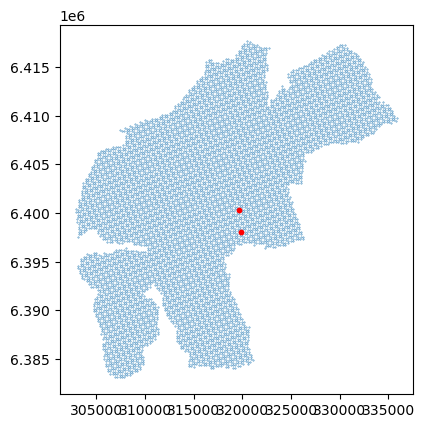

In [116]:
ax = origins.plot(markersize=0.1)

# Plot Chalmers and Central Station location in red
o_x,o_y = 319838.63006660575,6398032.68584987
d_x,d_y = 319654.0071406632, 6400282.674784801

ax.scatter(o_x,o_y, color='red', s=10)

ax.scatter(d_x,d_y, color='red', s=10)

# Going from any random point to closest point

## Experiment Summary: Querying Closest Points

In this experiment, we tested two methods for querying the closest points to a set of random coordinates using a dataset of origin points. The two methods compared are:

1. **get_closest_id function:** This method calculates the distance between each random coordinate and all origin points in the dataset and returns the ID of the closest origin point.

2. **get_closest_id_tree function:** This method uses a BallTree spatial indexing structure to efficiently find the closest origin point to each random coordinate and returns the ID of the closest origin point.

We measured the total time taken to query a varying number of random points and calculated the average time per query call for each method.

### Results

| Number of Random Points | get_closest_id (seconds) | get_closest_id_tree (seconds) |
|-------------------------|--------------------------|-------------------------------|
| 1                       | 0.015549                 | 0.000355                      |
| 10                      | 0.140009                 | 0.001297                      |
| 100                     | 1.309974                 | 0.013414                      |
| 1000                    | 12.895093                | 0.111098                      |
| 9000                    | 115.895936               | 1.005964                      |


In [209]:
# Lets create a function that takes a lat lon and returns closest id. Since we are uswing 3006 we do not need to transform

def get_closest_id(lat, lon,origins):
    # Create a point from lat lon
    point = gpd.points_from_xy([lon], [lat])
    # Create a geodataframe from the point
    point_gdf = gpd.GeoDataFrame(geometry=point)
    # Set crs to epsg 3006
    point_gdf.crs = "EPSG:3006"
    # Find the closest id
    closest_id = origins.loc[origins.distance(point_gdf.unary_union).idxmin(), 'id']
    return closest_id

In [178]:
# Lets test the function using using o_x and o_y
time_start = time.time()
closest_id = get_closest_id(o_y, o_x, origins)
# Print time for processing
print(f"Time for processing: {time.time() - time_start:.4f} seconds")
print(closest_id)

Time for processing: 0.0172 seconds
13614


In [179]:
# Lets turn this into a plotting function that takes a lat lon and returns the closest point and distance and plots it
def plot_closest_point(lat, lon, origins, closest_id):
    # Create a point from lat lon
    point = gpd.points_from_xy([lon], [lat])
    # Create a geodataframe from the point
    point_gdf = gpd.GeoDataFrame(geometry=point)
    # Set crs to epsg 3006
    point_gdf.crs = "EPSG:3006"
    # Get the closest point
    o_gdf = origins[origins['id'] == closest_id]
    # Plot the closest point
    ax = o_gdf.plot(markersize=10)
    ax.scatter(lon,lat, color='red', s=10)
    # Draw a line between the two points and calculate the distance
    line = LineString([(lon,lat), (o_gdf.geometry.x, o_gdf.geometry.y)])
    x,y = line.xy
    ax.plot(x,y, color='red', linewidth=1)
    # Calculate the distance
    distance = line.length
    ax.set_title(f"Distance from actual point to closest point: {distance:.2f} meters")
    # Add a legend
    plt.legend(['Closest point', 'Actual point'])
    return distance

13614


106.88578919454471

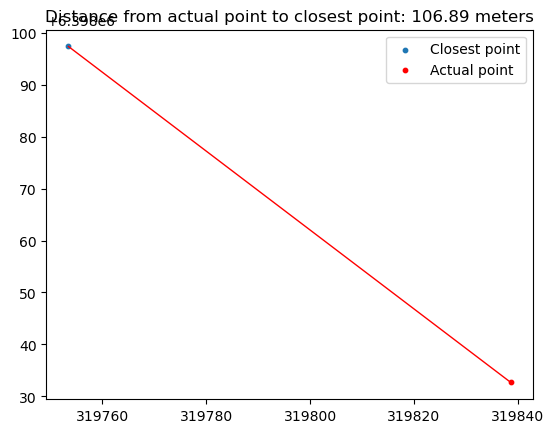

In [181]:
closest_id = get_closest_id(o_y, o_x, origins)
print(closest_id)
plot_closest_point(o_y, o_x, origins, closest_id)

13511


92.33261315692258

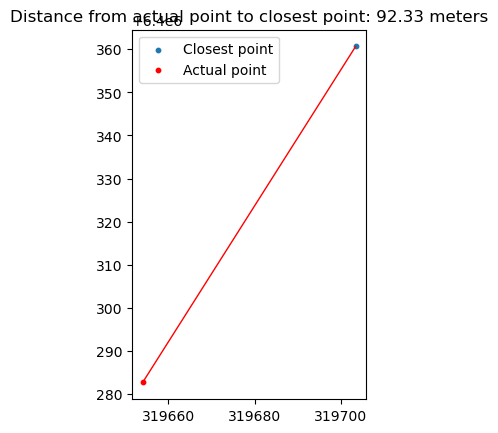

In [182]:
closest_id = get_closest_id(d_y, d_x, origins)
print(closest_id)
plot_closest_point(d_y, d_x, origins, closest_id)

## Trying a KDTree

In [196]:
 import numpy as np
 from sklearn.neighbors import KDTree

# Create a array of points with 2 dimensions (x and y) from the origins df
points = np.array(origins[['geometry']].apply(lambda x: [x[0].x, x[0].y], axis=1).tolist())
tree = KDTree(points)
ids = origins['id'].to_numpy()

def get_closest_id_tree(lat,lon,tree,ids):
    dist,closest_idx = tree.query([[lon,lat]])
    # Get closest id
    closest_id = ids[closest_idx][0][0]
    return closest_id

In [197]:
# Lets test the function using using o_x and o_y
time_start = time.time()
closest_id = get_closest_id_tree(o_y, o_x, tree,ids)
# Print time for processing
print(f"Time for processing: {time.time() - time_start:.6f} seconds")
print(closest_id)

Time for processing: 0.000000 seconds
13614


<class 'numpy.int64'>


106.88578919454471

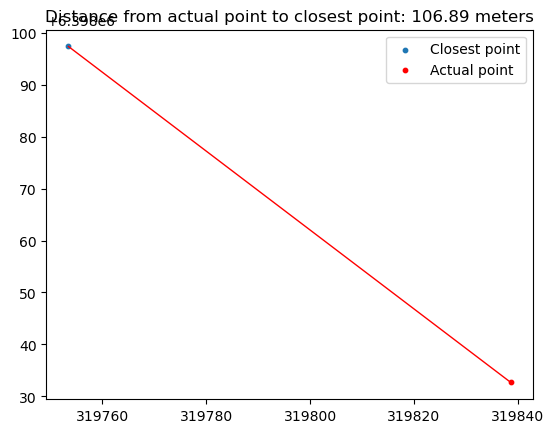

In [199]:
closest_id = get_closest_id_tree(o_y, o_x, tree,ids)
print(type(closest_id))
plot_closest_point(o_y, o_x, origins, closest_id)

13511


92.33261315692258

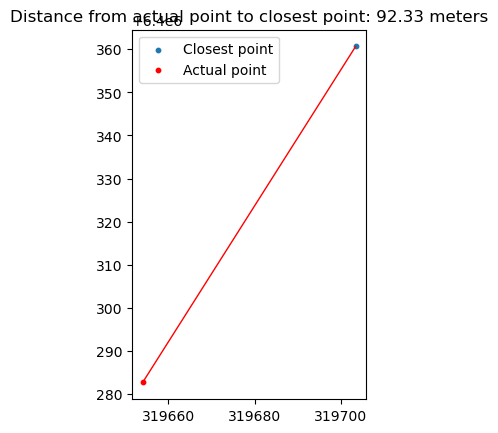

In [200]:
closest_id = get_closest_id_tree(d_y, d_x, tree,ids)
print(closest_id)
plot_closest_point(d_y, d_x, origins, closest_id)

In [207]:
# Comparing the two functions get_closest_id and get_closest_id_tree for 1, 10, 100, 1000, 10000 points from the origins df

# List of the number of OD pairs to query in each experiment
num_point_list = [1, 10, 100, 1000, 9000]

# Using the origins df lets create a dict of pairs
random_point_dict = {}

for num_points in num_point_list:
    # Efficiently sample random OD pairs using random.sample()
    random_points = random.sample(points.tolist(), num_points)

    # Store the random OD pairs
    random_point_dict[num_points] = random_points

In [210]:
# Lets first test the get_closest_id function
for num_points, points in random_point_dict.items():
    # Query the travel time for each origin-destination pair and measure the total time taken
    start_time = time.perf_counter()
    for point in points:
        get_closest_id(point[1], point[0], origins)
    total_query_time = time.perf_counter() - start_time

    # Calculate the average time per query call
    time_per_call = total_query_time / num_points

    # Print the total time and average time per call for querying the specified number of OD pairs
    print(f"Total time for querying {num_points} random points: {total_query_time:.6f} seconds")
    print(f"Average time per call: {time_per_call:.6f} seconds")

Total time for querying 1 random points: 0.015549 seconds
Average time per call: 0.015549 seconds
Total time for querying 10 random points: 0.140009 seconds
Average time per call: 0.014001 seconds
Total time for querying 100 random points: 1.309974 seconds
Average time per call: 0.013100 seconds
Total time for querying 1000 random points: 12.895093 seconds
Average time per call: 0.012895 seconds
Total time for querying 9000 random points: 115.895936 seconds
Average time per call: 0.012877 seconds


In [211]:
# Now lets test the get_closest_id_tree function
for num_points, points in random_point_dict.items():
    # Query the travel time for each origin-destination pair and measure the total time taken
    start_time = time.perf_counter()
    for point in points:
        get_closest_id_tree(point[1], point[0], tree, ids)
    total_query_time = time.perf_counter() - start_time

    # Calculate the average time per query call
    time_per_call = total_query_time / num_points

    # Print the total time and average time per call for querying the specified number of OD pairs
    print(f"Total time for querying {num_points} random points: {total_query_time:.6f} seconds")
    print(f"Average time per call: {time_per_call:.6f} seconds")

Total time for querying 1 random points: 0.000355 seconds
Average time per call: 0.000355 seconds
Total time for querying 10 random points: 0.001297 seconds
Average time per call: 0.000130 seconds
Total time for querying 100 random points: 0.013414 seconds
Average time per call: 0.000134 seconds
Total time for querying 1000 random points: 0.111098 seconds
Average time per call: 0.000111 seconds
Total time for querying 9000 random points: 1.005964 seconds
Average time per call: 0.000112 seconds


# Combining it all

Finally, what we really need is a way to get transit times between two random points.

| Query Count | Total Time (seconds) | Average Time per Call (seconds) |
|-------------|-----------------------|---------------------------------|
| 1           | 2.058234              | 2.058234                        |
| 10          | 2.055068              | 0.205507                        |
| 100         | 2.097684              | 0.020977                        |
| 1000        | 2.015695              | 0.002016                        |
| 9000        | 2.032059              | 0.000226                        |

This table summarizes the total time taken and the average time per call for querying different numbers of random OD pairs. While the total time remains the same, the average time per call is going down. This indicates that there is a 2 second overhead in the querying function.

But this can be avoided if you don't want the overhead of objectifying this process.

In [258]:
# Lets expand the ODMatrix class
class ODMatrix:
    def __init__(self, hdf5_path,origins_gdf):
        self.hdf5_path = hdf5_path
        self.travel_times_dict = {}
        self.origins_gdf = origins_gdf
        self.points = np.array(self.origins_gdf[['geometry']].apply(lambda x: [x[0].x, x[0].y], axis=1).tolist())
        self.tree = KDTree(self.points)
        self.ids = self.origins_gdf['id'].to_numpy()
        self.preprocess_data()


    def preprocess_data(self):
        """Preprocess the data from the HDF5 file and store it in a dictionary for fast lookups."""
        with h5py.File(self.hdf5_path, 'r') as hdf5_file:


            # Proceed with the existing logic if datasets are present
            dataset_size = hdf5_file['from_id'].shape[0]
            batch_size = 10000  # Adjust based on your system's memory capacity

            for i in range(0, dataset_size, batch_size):
                from_ids = hdf5_file['from_id'][i:i+batch_size]
                to_ids = hdf5_file['to_id'][i:i+batch_size]
                travel_times = hdf5_file['travel_time'][i:i+batch_size]
                
                for from_id, to_id, travel_time in zip(from_ids, to_ids, travel_times):
                    self.travel_times_dict[(from_id, to_id)] = travel_time
    
    def get_closest_id_tree(self,lat,lon):
        dist,closest_idx = self.tree.query([[lon,lat]])
        # Get closest id
        closest_id = self.ids[closest_idx][0][0]
        return closest_id
    
    def query_travel_time(self,o,d):
        # Get closest id
        origin_closest_id = self.get_closest_id_tree(o[1], o[0])
        # Get closest id
        destination_closest_id = self.get_closest_id_tree(d[1], d[0])
        # Query the travel time for a given origin and destination ID pair.
        travel_time = self.travel_times_dict.get((origin_closest_id, destination_closest_id), None)
        return travel_time


In [236]:
# Test the class
od_matrix = ODMatrix(path_to_hdf5, origins)

In [240]:
# Testing the query_travel_time function
time_start = time.time()
travel_time = od_matrix.query_travel_time([o_x,o_y], [d_x,d_y])
# Print time for processing
print(f"Time for processing: {time.time() - time_start:.6f} seconds")
print(travel_time)


Time for processing: 0.001159 seconds
54


In [251]:
# Testing this at scale
# List of the number of OD pairs to query in each experiment
num_pairs_list = [1, 10, 100, 1000, 9000]

# Convert the dictionary keys to a list once, outside the loop
points = np.array(origins[['geometry']].apply(lambda x: [x[0].x, x[0].y], axis=1).tolist())

# Pre-generate all random OD pairs and store them
random_os = {}
random_ds = {}

for num_pairs in num_pairs_list:
    
    # Efficiently sample random OD pairs using random.sample()
    random_os = random.sample(points.tolist(), num_pairs)
    random_ds = random.sample(points.tolist(), num_pairs)

    # Store the random OD pairs
    random_od_pairs_dict[num_pairs] = random_od_pairs


In [257]:
# Iterate over the stored OD pairs and measure query times
for num_pairs, od_pairs in random_od_pairs_dict.items():
    # Query the travel time for each origin-destination pair and measure the total time taken
    start_time = time.perf_counter()
    for o,d in zip(random_os,random_ds):
        od_matrix.query_travel_time(o, d)
    total_query_time = time.perf_counter() - start_time
    
    # Calculate the average time per query call
    time_per_call = total_query_time / num_pairs

    # Print the total time and average time per call for querying the specified number of OD pairs
    print(f"Total time for querying {num_pairs} random OD pairs: {total_query_time:.6f} seconds")
    print(f"Average time per call: {time_per_call:.6f} seconds")
    

Total time for querying 1 random OD pairs: 2.058234 seconds
Average time per call: 2.058234 seconds
Total time for querying 10 random OD pairs: 2.055068 seconds
Average time per call: 0.205507 seconds
Total time for querying 100 random OD pairs: 2.097684 seconds
Average time per call: 0.020977 seconds
Total time for querying 1000 random OD pairs: 2.015695 seconds
Average time per call: 0.002016 seconds
Total time for querying 9000 random OD pairs: 2.032059 seconds
Average time per call: 0.000226 seconds
